<a href="https://colab.research.google.com/github/karam-koujan/dog-vs-cat-classification/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle


In [2]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mlrond","key":"fbae98785636cd498845ad590845bb9b"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/



In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
 !kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          32003        872  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           3719        107  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           5944        127  1.0              
mohithsairamreddy/salary-data 

In [7]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:37<00:00, 21.8MB/s]
100% 812M/812M [00:37<00:00, 22.6MB/s]


In [8]:
!unzip -qq dogs-vs-cats
!unzip -qq train.zip

In [9]:
import os, shutil, pathlib

In [10]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats-small")


In [11]:
def make_subset(subset_name,start_idx,end_idx):
    for category in ("cat","dog"):
       dir = new_base_dir / subset_name / category
       os.makedirs(dir)
       fnames = [f"{category}.{i}.jpg" for i in range(start_idx,end_idx)]
       for fname in fnames :
           shutil.copyfile(src=original_dir/fname,dst=dir/fname)
make_subset("train",0,1000)
make_subset("validation",1000,1500)
make_subset("test",1500,2500)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory
train_dataset = image_dataset_from_directory(new_base_dir/"train",image_size=(180,180),batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir/"validation",image_size=(180,180),batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir/"test",image_size=(180,180),batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [14]:
for data_batch, label_batch in train_dataset :
   print("data batch",data_batch.shape)
   print("label batch",label_batch.shape)
   break

data batch (32, 180, 180, 3)
label batch (32,)


In [15]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [16]:
conv_base.trainable_weights

[<tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
 array([[[[-6.0689339e-04,  1.4231558e-03,  7.3316055e-03, ...,
            2.6178278e-03,  4.3357504e-04, -2.9434897e-03],
          [-4.8605306e-03,  4.9075234e-04, -1.2511463e-03, ...,
            1.1560039e-03, -1.2683710e-04, -1.5934335e-02],
          [ 8.2136225e-03,  7.4967248e-03,  4.4443067e-03, ...,
           -1.0573096e-02, -1.3803735e-02, -2.0028956e-03],
          ...,
          [ 2.0234480e-03, -5.8380342e-03, -2.3825851e-03, ...,
            1.3192679e-03, -8.6920448e-03, -8.2156417e-04],
          [ 7.9414165e-03, -8.0086980e-03,  7.7348115e-04, ...,
            9.1014095e-03,  6.8836473e-04, -9.8630879e-03],
          [ 7.3094536e-03, -1.1607672e-03,  5.1686643e-03, ...,
           -1.8046533e-03, -7.7111748e-05,  3.5778836e-03]],
 
         [[-1.5249068e-03, -3.1574788e-03,  4.5571220e-03, ...,
           -8.1634670e-03, -8.1500728e-03, -5.8323247e-03],
          [-1.2195857e-03, -5.4



---





In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [18]:

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x - keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model = keras.Model(inputs,outputs)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath= "fine_tuning.keras",
        save_best_only=True,
        monitor= "val_loss"
    )
]
history = model.fit(train_dataset,epochs=50,validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 27s 206ms/step - loss: 4.4206 - accuracy: 0.6985 - val_loss: 0.8202 - val_accuracy: 0.8940
Epoch 2/50
63/63 [==============================] - 10s 157ms/step - loss: 1.4398 - accuracy: 0.8155 - val_loss: 0.6121 - val_accuracy: 0.9160
Epoch 3/50
63/63 [==============================] - 10s 160ms/step - loss: 0.8991 - accuracy: 0.8520 - val_loss: 0.3563 - val_accuracy: 0.9360
Epoch 4/50
63/63 [==============================] - 10s 157ms/step - loss: 0.5746 - accuracy: 0.8790 - val_loss: 0.2802 - val_accuracy: 0.9380
Epoch 5/50
63/63 [==============================] - 10s 158ms/step - loss: 0.3937 - accuracy: 0.8920 - val_loss: 0.2526 - val_accuracy: 0.9470
Epoch 6/50
63/63 [==============================] - 10s 161ms/step - loss: 0.3068 - accuracy: 0.9015 - val_loss: 0.2489 - val_accuracy: 0.9410
Epoch 7/50
63/63 [==============================] - 11s 168ms/step - loss: 0.2704 - accuracy: 0.9130 - val_loss: 0.1869 - val_accuracy: 0.9510

In [19]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss,test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}, Test loss: {test_loss}")

63/63 [==============================] - 6s 92ms/step - loss: 0.2261 - accuracy: 0.9555
Test accuracy:  0.956, Test loss: 0.22605080902576447


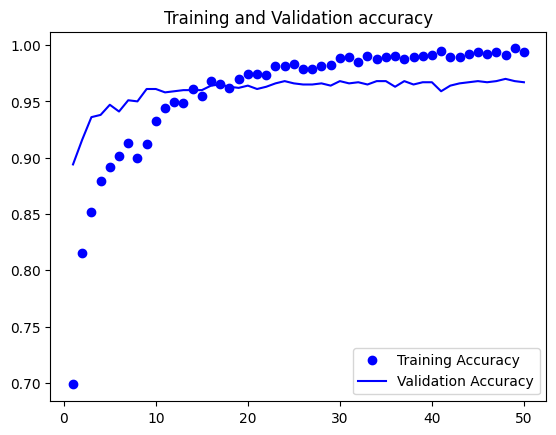

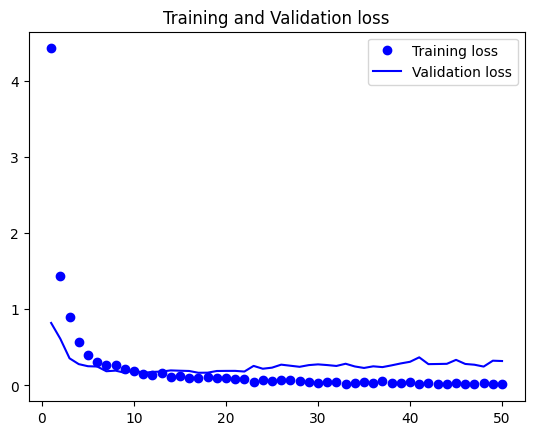

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,"bo",label="Training Accuracy")
plt.plot(epochs,val_accuracy,"b",label="Validation Accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs,loss,"bo",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()
